1. Language used : PySpark
2. Worked on adult dataset and generated synthetic data from adult dataset
3. Creating Model & comparisons 

In [32]:
!pip3 uninstall -y synthpop

Found existing installation: synthpop 0.1.1
Uninstalling synthpop-0.1.1:
  Successfully uninstalled synthpop-0.1.1


In [35]:
!pip3 uninstall -y py-synthpop

Found existing installation: py-synthpop 0.1.2
Uninstalling py-synthpop-0.1.2:
  Successfully uninstalled py-synthpop-0.1.2


In [1]:
### Import statements
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
import json
#import gcsfs

In [5]:
#!pip install google-auth-oauthlib==0.4.6

In [2]:
pip install py-synthpop

Note: you may need to restart the kernel to use updated packages.


In [3]:
## Building a spark session
spark = SparkSession.builder \
.appName("synthpop").enableHiveSupport()\
.getOrCreate()

In [4]:
## Import the synthpop 
from synthpop import Synthpop
spop = Synthpop()

In [5]:
csv_path = "synthpop_datasets/adult.data"
json_path = "synthpop_datasets/dtypes.json"

with open(json_path, 'r') as f:
  dtypes = json.load(f)

In [6]:
## Get the columns
columns = list(dtypes.keys())

In [7]:
## Reading the dataframe from csv file
adult_df = pd.read_csv(csv_path, header=None, names=columns).astype(dtypes)

In [8]:
adult_df.dtypes

age                   int64
workclass          category
fnlwgt                int64
education          category
educational-num       int64
marital-status     category
occupation         category
relationship       category
race               category
gender             category
capital-gain          int64
capital-loss          int64
hours-per-week        int64
native-country     category
income             category
dtype: object

In [9]:
adult_spark_df = spark.createDataFrame(adult_df)
adult_spark_preprocessed_df = adult_spark_df.where((F.col('occupation')!='?') & (F.col('native-country')!='?') & (F.col('workclass')!='?'))

In [10]:
adult_spark_preprocessed_df.show(2,False)

+---+----------------+------+---------+---------------+------------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass       |fnlwgt|education|educational-num|marital-status    |occupation     |relationship |race |gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+----------------+------+---------+---------------+------------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|39 |State-gov       |77516 |Bachelors|13             |Never-married     |Adm-clerical   |Not-in-family|White|Male  |2174        |0           |40            |United-States |<=50K |
|50 |Self-emp-not-inc|83311 |Bachelors|13             |Married-civ-spouse|Exec-managerial|Husband      |White|Male  |0           |0           |13            |United-States |<=50K |
+---+----------------+------+---------+---------------+------------------+---------------+-----

In [11]:
adult_spark_preprocessed_df.count()

30162

In [12]:
adult_spark_preprocessed_df.printSchema()

root
 |-- age: long (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: long (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: long (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: long (nullable = true)
 |-- capital-loss: long (nullable = true)
 |-- hours-per-week: long (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



In [13]:
## Listing out all the columns
cols = adult_spark_preprocessed_df.columns

In [14]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [15]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(adult_spark_preprocessed_df)
adult_df1 = pipelineModel.transform(adult_spark_preprocessed_df)
selectedCols = ['label', 'features'] + cols
adult_df1 = adult_df1.select(selectedCols)

In [16]:
train_adult, test_adult = adult_df1.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_adult.count()))
print("Test Dataset Count: " + str(test_adult.count()))

Training Dataset Count: 21077
Test Dataset Count: 9085


In [18]:
test_adult.show(10,False)

+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+
|label|features                                                                                                   |age|workclass|fnlwgt|education|educational-num|marital-status    |occupation    |relationship|race |gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,94,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,32.0,130304.0,9.0,1485.0,48.0])|32 |Private  |130304|HS-gra

In [17]:
test_adult.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: long (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: long (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: long (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: long (nullable = true)
 |-- capital-loss: long (nullable = true)
 |-- hours-per-week: long (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



In [156]:
firstelement=udf(lambda v:int(v[0]),IntegerType())
test_adult.select(firstelement('features')).distinct().show(100,False)

+------------------+
|<lambda>(features)|
+------------------+
|1                 |
|0                 |
+------------------+



#### Modelling

In [19]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_adult)

#### Save the Model

In [20]:
mPath = "synthpop_datasets/models/model_adult_pyspark_30k"

In [21]:
# writing the model
from pyspark.ml import PipelineModel
lrModel.write().overwrite().save(mPath)

#### Load the Model

In [22]:
from pyspark.ml.classification import LogisticRegressionModel
model_adult = LogisticRegressionModel.load(mPath)

In [23]:
predictions_adult_test_data = model_adult.transform(test_adult)
predictions_adult_test_data.select('label', 'rawPrediction', 'prediction', 'probability').show(3,False)

+-----+------------------------------------------+----------+---------------------------------------+
|label|rawPrediction                             |prediction|probability                            |
+-----+------------------------------------------+----------+---------------------------------------+
|0.0  |[-0.23731976042759229,0.23731976042759229]|1.0       |[0.4409469589751305,0.5590530410248695]|
|0.0  |[0.6598532512717856,-0.6598532512717856]  |0.0       |[0.659227422614798,0.34077257738520195]|
|0.0  |[1.3926798253862884,-1.3926798253862884]  |0.0       |[0.8010197174070638,0.1989802825929362]|
+-----+------------------------------------------+----------+---------------------------------------+
only showing top 3 rows



In [24]:
accuracy = predictions_adult_test_data.filter(predictions_adult_test_data.label == predictions_adult_test_data.prediction).count() / float(predictions_adult_test_data.count())
print("Accuracy : ",accuracy)
#Accuracy :  0.8423309510720176 - 10 Iterations
#Accuracy :  0.7569847704612688 - one time run model accuracy

Accuracy :  0.8485415520088058


In [25]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1382  884]
 [ 492 6327]]


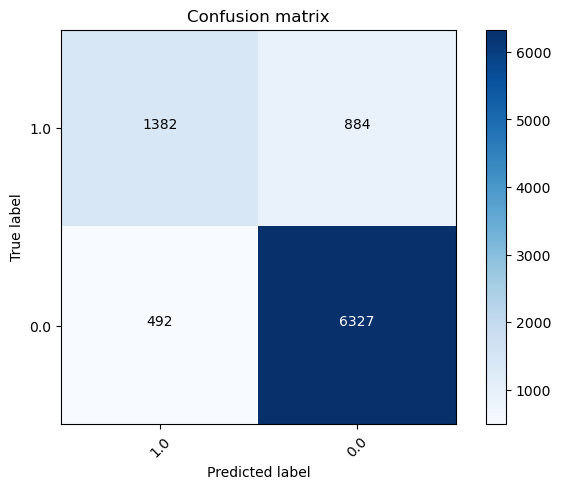

In [26]:
y_true = predictions_adult_test_data.select("label")
y_true = y_true.toPandas()

y_pred = predictions_adult_test_data.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [27]:
predictions_adult_test_data.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)


+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |1382|
|0.0       |1.0  |884 |
|1.0       |0.0  |492 |
|0.0       |0.0  |6327|
+----------+-----+----+



#### Generating synthetic data and building a model and checking the performance

In [28]:
preprocessed_adult_df = adult_df[~(adult_df['workclass'] == '?') & \
                            ~(adult_df['occupation'] == '?') & ~(adult_df['native-country'] == '?')]

In [29]:
spop.fit(preprocessed_adult_df, dtypes)

/opt/conda/lib/python3.11/site-packages/synthpop/validator/validator.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, _ in self.spop.visit_sequence.sort_values().iteritems():
/opt/conda/lib/python3.11/site-packages/synthpop/synthpop.py:73: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, visit_step in self.visit_sequence.sort_values().iteritems():


train_age
train_workclass
train_fnlwgt
train_education
train_educational-num
train_marital-status
train_occupation
train_relationship
train_race
train_gender
train_capital-gain
train_capital-loss
train_hours-per-week
train_native-country
train_income


In [30]:
synth_full_df = spop.generate(len(preprocessed_adult_df))

/opt/conda/lib/python3.11/site-packages/synthpop/synthpop.py:99: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, visit_step in self.visit_sequence.sort_values().iteritems():


generate_age
generate_workclass
generate_fnlwgt
generate_education
generate_educational-num
generate_marital-status
generate_occupation
generate_relationship
generate_race
generate_gender
generate_capital-gain
generate_capital-loss
generate_hours-per-week
generate_native-country
generate_income


In [31]:
synth_full_df.to_csv("synthpop_datasets/synthesized_df_30k",index=False)

In [32]:
synth_df_30k = pd.read_csv("synthpop_datasets/synthesized_df_30k")

In [33]:
synth_df_30k.head(2)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,73,Private,192740,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,20,United-States,<=50K
1,19,Federal-gov,431745,Some-college,10,Never-married,Handlers-cleaners,Unmarried,Black,Female,0,0,35,United-States,<=50K


In [34]:
synth_spark_full_df = spark.createDataFrame(synth_df_30k)

In [63]:
## Listing out all the columns
cols = synth_spark_full_df.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
# print(stringIndexer.getOutputCol())  # This will print "categoricalColIndex"
#print(encoder.getOutputCols())  # This will print ["categoricalColVec"]
print("stages:",len(stages))

label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
print("stages after label:",len(stages))

numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
# print("assemblerInputs:",len(assemblerInputs))

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
print("stages:",stages)

from pyspark.ml import Pipeline
pipeline_synth = Pipeline(stages = stages)
pipelineModel_synth = pipeline_synth.fit(synth_spark_full_df)
synth_full_df1 = pipelineModel_synth.transform(synth_spark_full_df)
selectedCols = ['label', 'features'] + cols
synth_full_df1 = synth_full_df1.select(selectedCols)

synth_full_df1.select("features","label").show(5,False)
train_synth, test_synth = synth_full_df1.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_synth.count()))
print("Test Dataset Count: " + str(test_synth.count()))

from pyspark.ml.classification import LogisticRegression
lr_full_data = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_synth = lr_full_data.fit(train_synth)


stages: 16
stages after label: 17
stages: [StringIndexer_5f3de39ba705, OneHotEncoder_cf286575a551, StringIndexer_25263823b1e0, OneHotEncoder_e9fbd0b43892, StringIndexer_bd10bca88d6a, OneHotEncoder_5a951bf8f47f, StringIndexer_56f86d7f5689, OneHotEncoder_0f5f1ba1cbc4, StringIndexer_5f632419dc87, OneHotEncoder_5a0572d0196a, StringIndexer_b9f10c658f6e, OneHotEncoder_e16060aeefe2, StringIndexer_3b354ade78a8, OneHotEncoder_e5a51db21859, StringIndexer_87c058ef0c82, OneHotEncoder_77da41295d59, StringIndexer_ecf1466bae8d, VectorAssembler_3dfccb529c5b]
+---------------------------------------------------------------------------------------------------+-----+
|features                                                                                           |label|
+---------------------------------------------------------------------------------------------------+-----+
|(96,[0,6,21,33,44,45,50,90,91,92,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,73.0,192740.0,9.0,20.0])         |0.0  |
|(96,[5,7,22,35,43,

In [61]:
s = [0,6,21,33,44,45,50,90,91,92,95]
len(s)

11

In [50]:
import sys
print(sys.version)

3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:17) [GCC 12.2.0]


In [51]:
import platform
print(platform.python_version())

3.11.4


In [52]:
import pyspark
print(f"PySpark version: {pyspark.__version__}")

PySpark version: 3.4.1


In [45]:
train_synth.show(10,False)

+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+------------+------------+-----+------+------------+------------+--------------+--------------+------+
|label|features                                                                                                   |age|workclass|fnlwgt|education|educational-num|marital-status    |occupation  |relationship|race |gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+------------+------------+-----+------+------------+------------+--------------+--------------+------+
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,93,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,33.0,34574.0,9.0,3908.0,40.0]) |33 |Private  |34574 |HS-grad  |9 

In [ ]:
+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+------------+------------+-----+------+------------+------------+--------------+--------------+------+
|label|features                                                                                                   |age|workclass|fnlwgt|education|educational-num|marital-status    |occupation  |relationship|race |gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+------------+------------+-----+------+------------+------------+--------------+--------------+------+
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,93,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,33.0,34574.0,9.0,3908.0,40.0]) |33 |Private  |34574 |HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |3908        |0           |40            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,93,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,100109.0,9.0,3103.0,40.0])|50 |Private  |100109|HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |3103        |0           |40            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,93,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,68.0,163346.0,9.0,2290.0,16.0])|68 |Private  |163346|HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |2290        |0           |16            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,94,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,34310.0,9.0,2002.0,35.0]) |20 |Private  |34310 |HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |0           |2002        |35            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,94,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,56.0,174744.0,9.0,1485.0,40.0])|56 |Private  |174744|HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |0           |1485        |40            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,184016.0,9.0,40.0])          |18 |Private  |184016|HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |0           |0           |40            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,34310.0,9.0,25.0])           |20 |Private  |34310 |HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |0           |0           |25            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,509629.0,9.0,40.0])          |24 |Private  |509629|HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |0           |0           |40            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,26.0,199143.0,9.0,48.0])          |26 |Private  |199143|HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |0           |0           |48            |United-States |<=50K |
|0.0  |(96,[0,6,21,27,40,45,49,50,90,91,92,95],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.0,270973.0,9.0,40.0])          |28 |Private  |270973|HS-grad  |9              |Married-civ-spouse|Craft-repair|Husband     |White|Male  |0           |0           |40            |United-States |<=50K |
+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+------------+------------+-----+------+------------+------------+--------------+--------------+------+

In [36]:
# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/synth_model_pyspark_30k"
lrModel_synth.write().overwrite().save(mPath)

In [37]:
from pyspark.ml.classification import LogisticRegressionModel
synth_model_30k = LogisticRegressionModel.load(mPath)

#### Predictions on 30% Synthetic data 

In [38]:
pred_synth_30k = synth_model_30k.transform(test_synth)

accuracy = pred_synth_30k.filter(pred_synth_30k.label == pred_synth_30k.prediction).count() / float(pred_synth_30k.count())
print("Accuracy : ",accuracy)


Accuracy :  0.839686222516849


#### Pulling up the confusion matrix

In [39]:
pred_synth_30k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)


+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |1317|
|0.0       |1.0  |934 |
|1.0       |0.0  |517 |
|0.0       |0.0  |6283|
+----------+-----+----+



#### Load the synthetic model and predict on 30% original Test data

In [40]:
mPath = "synthpop_datasets/models/synth_model_pyspark_30k"
from pyspark.ml.classification import LogisticRegressionModel
synth_model_30k = LogisticRegressionModel.load(mPath)

In [41]:
pred_adult_test = synth_model_30k.transform(test_adult)

In [42]:
pred_adult_test.show(10,False)

+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+--------------+------------+-----+------+------------+------------+--------------+--------------+------+--------------------------------------------+----------------------------------------+----------+
|label|features                                                                                                   |age|workclass|fnlwgt|education|educational-num|marital-status    |occupation    |relationship|race |gender|capital-gain|capital-loss|hours-per-week|native-country|income|rawPrediction                               |probability                             |prediction|
+-----+-----------------------------------------------------------------------------------------------------------+---+---------+------+---------+---------------+------------------+--------------+------------+-----+------+------------

In [43]:
pred_adult_test.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |1343|
|0.0       |1.0  |923 |
|1.0       |0.0  |487 |
|0.0       |0.0  |6332|
+----------+-----+----+



In [44]:
accuracy = pred_adult_test.filter(pred_adult_test.label == pred_adult_test.prediction).count() / float(pred_adult_test.count())
print("Accuracy : ",accuracy)


Accuracy :  0.844799119427628


#### Approach1:
#### Generate 10k from the original data and create a logistic model

In [69]:
synth_df_10k = pd.read_csv("synthpop_datasets/synth_10k")

In [70]:
synth_spark_df_10k = spark.createDataFrame(synth_df_10k)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [73]:
## Listing out all the columns
cols = synth_spark_df_10k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_10k = Pipeline(stages = stages)
pipelineModel_10k = pipeline_10k.fit(synth_spark_df_10k)
synth_df1_10k = pipelineModel_10k.transform(synth_spark_df_10k)
selectedCols = ['label', 'features'] + cols
synth_df1_10k = synth_df1_10k.select(selectedCols)

train_synth_10k, test_synth_10k = synth_df1_10k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_synth_10k.count()))
print("Test Dataset Count: " + str(test_synth_10k.count()))

from pyspark.ml.classification import LogisticRegression
lr_10k = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_10k = lr_10k.fit(train_synth_10k)


Training Dataset Count: 7992
Test Dataset Count: 2008


#### Save the Model

In [74]:
# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/synth_model_pyspark_10k"
lrModel_10k.write().overwrite().save(mPath)

#### Load the Model

In [75]:
from pyspark.ml.classification import LogisticRegressionModel
synth_model_10k = LogisticRegressionModel.load(mPath)

In [76]:
pred_synth_10k = synth_model_10k.transform(test_synth_10k)

accuracy = pred_synth_10k.filter(pred_synth_10k.label == pred_synth_10k.prediction).count() / float(pred_synth_10k.count())
print("Accuracy : ",accuracy)


Accuracy :  0.8351593625498008


Confusion matrix, without normalization
[[ 312  221]
 [ 110 1365]]


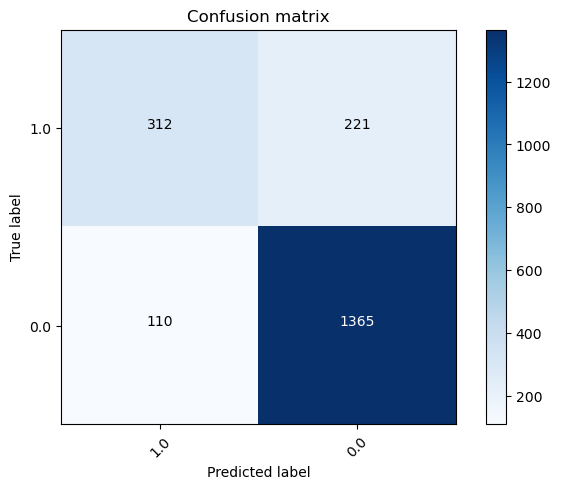

In [77]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_true = pred_synth_10k.select("label")
y_true = y_true.toPandas()

y_pred = pred_synth_10k.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()


In [78]:
pred_synth_10k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)


+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |312 |
|0.0       |1.0  |221 |
|1.0       |0.0  |110 |
|0.0       |0.0  |1365|
+----------+-----+----+



#### Approach2:
#### Generate 15k from the original data and create a logistic model

In [79]:
synth_df_15k = pd.read_csv("synthpop_datasets/synth_15k")

In [80]:
synth_spark_df_15k = spark.createDataFrame(synth_df_15k)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [82]:
## Listing out all the columns
cols = synth_spark_df_15k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_15k = Pipeline(stages = stages)
pipelineModel_15k = pipeline_15k.fit(synth_spark_df_15k)
synth_df1_15k = pipelineModel_15k.transform(synth_spark_df_15k)
selectedCols = ['label', 'features'] + cols
synth_df1_15k = synth_df1_15k.select(selectedCols)

train_synth_15k, test_synth_15k = synth_df1_15k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_synth_15k.count()))
print("Test Dataset Count: " + str(test_synth_15k.count()))

from pyspark.ml.classification import LogisticRegression
lr_15k = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_15k = lr_15k.fit(train_synth_15k)


Training Dataset Count: 11981
Test Dataset Count: 3019


#### Save the Model

In [35]:
# writing the model
from pyspark.ml import PipelineModel
mPath = "gs://vifl-rnd-ayyappa/synthpop_datasets/models/synth_model_pyspark_15k"
lrModel_15k.write().overwrite().save(mPath)

#### Load the Model

In [36]:
from pyspark.ml.classification import LogisticRegressionModel
synth_model_15k = LogisticRegressionModel.load(mPath)

In [37]:
pred_synth_15k = synth_model_15k.transform(test_synth_15k)

accuracy = pred_synth_15k.filter(pred_synth_15k.label == pred_synth_15k.prediction).count() / float(pred_synth_15k.count())
print("Accuracy : ",accuracy)


Accuracy :  0.8466421650517875


Confusion matrix, without normalization
[[ 419  308]
 [ 151 2115]]


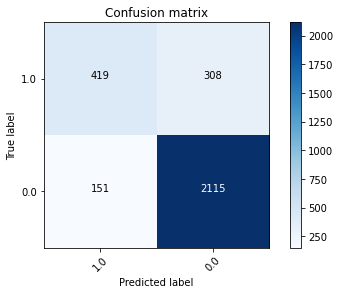

In [38]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_true = pred_synth_15k.select("label")
y_true = y_true.toPandas()

y_pred = pred_synth_15k.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()


In [39]:
pred_synth_15k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)


+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |419 |
|0.0       |1.0  |308 |
|1.0       |0.0  |151 |
|0.0       |0.0  |2115|
+----------+-----+----+



#### Approach3:
#### Generate 20k from the original data and create a logistic model

In [83]:
synth_df_20k = pd.read_csv("synthpop_datasets/synth_20k")

In [84]:
synth_spark_df_20k = spark.createDataFrame(synth_df_20k)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [85]:
## Listing out all the columns
cols = synth_spark_df_20k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_20k = Pipeline(stages = stages)
pipelineModel_20k = pipeline_20k.fit(synth_spark_df_20k)
synth_df1_20k = pipelineModel_20k.transform(synth_spark_df_20k)
selectedCols = ['label', 'features'] + cols
synth_df1_20k = synth_df1_20k.select(selectedCols)

train_synth_20k, test_synth_20k = synth_df1_20k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_synth_20k.count()))
print("Test Dataset Count: " + str(test_synth_20k.count()))

from pyspark.ml.classification import LogisticRegression
lr_20k = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_20k = lr_20k.fit(train_synth_20k)


Training Dataset Count: 15960
Test Dataset Count: 4040


#### Load and Save the Model

In [86]:
# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/synth_model_pyspark_20k"
lrModel_20k.write().overwrite().save(mPath)

from pyspark.ml.classification import LogisticRegressionModel
synth_model_20k = LogisticRegressionModel.load(mPath)

#### Predictions on Test data

In [87]:
pred_synth_20k = synth_model_20k.transform(test_synth_20k)

accuracy = pred_synth_20k.filter(pred_synth_20k.label == pred_synth_20k.prediction).count() / float(pred_synth_20k.count())
print("Accuracy : ",accuracy)


Accuracy :  0.843069306930693


Confusion matrix, without normalization
[[ 584  431]
 [ 203 2822]]


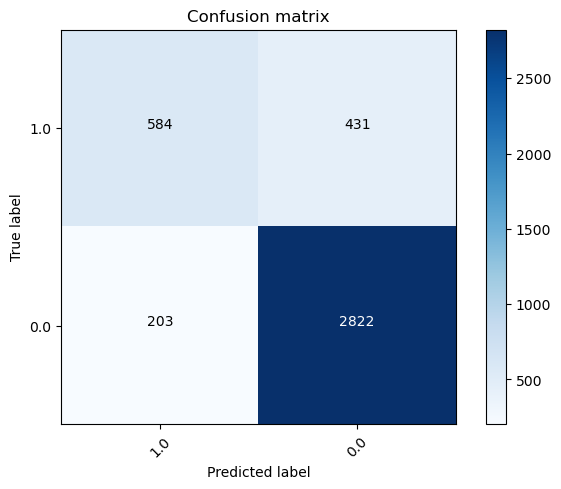

In [88]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_true = pred_synth_20k.select("label")
y_true = y_true.toPandas()

y_pred = pred_synth_20k.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()


In [89]:
pred_synth_20k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |584 |
|0.0       |1.0  |431 |
|1.0       |0.0  |203 |
|0.0       |0.0  |2822|
+----------+-----+----+



#### Loading the synthetic model(10k) and predict on original data of 10k

In [90]:
sample_adult_df_10k = adult_spark_preprocessed_df.sample(False,0.33028,seed=123) #10k

In [91]:
#sample_adult_df_10k.write.mode('overwrite').parquet('gs://vifl-rnd-ayyappa/synthpop_datasets/adult_10k')
sample_adult_df_10k = spark.read.parquet('synthpop_datasets/adult_10k')

In [92]:
## Listing out all the columns
cols = sample_adult_df_10k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_adult_10k = Pipeline(stages = stages)
pipelineModel_adult_10k = pipeline_adult_10k.fit(sample_adult_df_10k)
adult_df1_10k = pipelineModel_adult_10k.transform(sample_adult_df_10k)
selectedCols = ['label', 'features'] + cols
adult_df1_10k = adult_df1_10k.select(selectedCols)


In [93]:
len(adult_df1_10k.columns)

17

In [94]:
train_adult_10k, test_adult_10k = adult_df1_10k.randomSplit([0.79845, 0.20155], seed = 2018)
print("Training Dataset Count: " + str(train_adult_10k.count()))
print("Test Dataset Count: " + str(test_adult_10k.count()))

Training Dataset Count: 7969
Test Dataset Count: 2031


In [75]:
#train_adult_10k.write.mode('overwrite').parquet('gs://vifl-rnd-ayyappa/synthpop_datasets/train_adult_10k')
#test_adult_10k.write.mode('overwrite').parquet('gs://vifl-rnd-ayyappa/synthpop_datasets/test_adult_10k')

In [95]:
train_adult_10k = spark.read.parquet('synthpop_datasets/train_adult_10k')
test_adult_10k = spark.read.parquet('synthpop_datasets/test_adult_10k')

#### Load the synthetic model

In [ ]:
#7978 , 2022

In [96]:
mPath = "synthpop_datasets/models/synth_model_pyspark_10k"
from pyspark.ml.classification import LogisticRegressionModel
synth_model_10k = LogisticRegressionModel.load(mPath)

In [97]:
pred_adult_10k = synth_model_10k.transform(test_adult_10k)

In [98]:
accuracy = pred_adult_10k.filter(pred_adult_10k.label == pred_adult_10k.prediction).count() / float(pred_adult_10k.count())
print("Accuracy : ",accuracy)

Py4JJavaError: An error occurred while calling o8682.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 462.0 failed 1 times, most recent failure: Lost task 0.0 in stage 462.0 (TID 1593) (48135be0fed5 executor driver): org.apache.spark.SparkException: Failed to execute user defined function (ProbabilisticClassificationModel$$Lambda$4315/0x0000000801ceb3e0: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 96, y.size = 94
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:125)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:1156)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:1155)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1246)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1055)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 16 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (ProbabilisticClassificationModel$$Lambda$4315/0x0000000801ceb3e0: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 96, y.size = 94
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:125)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:1156)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:1155)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1246)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1055)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 16 more


In [99]:
pred_adult_10k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

Py4JJavaError: An error occurred while calling o8696.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 463.0 failed 1 times, most recent failure: Lost task 1.0 in stage 463.0 (TID 1596) (48135be0fed5 executor driver): org.apache.spark.SparkException: Failed to execute user defined function (ProbabilisticClassificationModel$$Lambda$4315/0x0000000801ceb3e0: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 96, y.size = 94
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:125)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:1156)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:1155)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1246)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1055)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 16 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (ProbabilisticClassificationModel$$Lambda$4315/0x0000000801ceb3e0: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 96, y.size = 94
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:125)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:1156)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:1155)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1246)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1055)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 16 more


##### TOOK 10K SAMPLE FROM THE ORIGINAL DATA AND CHECK THE MODEL PERFORMANCE

In [100]:
sample_adult_df_10k = spark.read.parquet('synthpop_datasets/adult_10k')

In [13]:
## Listing out all the columns
cols = sample_adult_df_10k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_adult_10k = Pipeline(stages = stages)
pipelineModel_adult_10k = pipeline_adult_10k.fit(sample_adult_df_10k)
adult_df1_10k = pipelineModel_adult_10k.transform(sample_adult_df_10k)
selectedCols = ['label', 'features'] + cols
adult_df1_10k = adult_df1_10k.select(selectedCols)


#### Train and Test

In [101]:
train_adult_10k, test_adult_10k = adult_df1_10k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_adult_10k.count()))
print("Test Dataset Count: " + str(test_adult_10k.count()))

Training Dataset Count: 7986
Test Dataset Count: 2014


#### Modelling

In [102]:
from pyspark.ml.classification import LogisticRegression
lr_adult_10k = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_adult_10k = lr_adult_10k.fit(adult_df1_10k)

#### Load and Save the Model

In [103]:
# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/adult_model_pyspark_10k"
lrModel_adult_10k.write().overwrite().save(mPath)

from pyspark.ml.classification import LogisticRegressionModel
lrModel_adult_10k = LogisticRegressionModel.load(mPath)

In [104]:
from pyspark.ml.classification import LogisticRegressionModel


In [105]:
pred_adult_10k = lrModel_adult_10k.transform(test_adult_10k)

In [106]:
accuracy = pred_adult_10k.filter(pred_adult_10k.label == pred_adult_10k.prediction).count() / float(pred_adult_10k.count())
print("Accuracy : ",accuracy)

#Accuracy :  0.8498753117206983

Accuracy :  0.8421052631578947


In [107]:
pred_adult_10k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |307 |
|0.0       |1.0  |201 |
|1.0       |0.0  |117 |
|0.0       |0.0  |1389|
+----------+-----+----+



#### Creating 5 different samples of 10k Records from original data

In [108]:
adult_df_sample_1 = adult_spark_preprocessed_df.sample(False,0.32865,seed=8394) #10k

In [109]:
adult_df_sample_1.count()

9972

In [110]:
adult_df_sample_1.write.mode('overwrite').parquet('synthpop_datasets/adult_10k_sample_1')
sample_1_10k = spark.read.parquet('synthpop_datasets/adult_10k_sample_1')

In [111]:
## Listing out all the columns
cols = sample_1_10k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_samp1_10k = Pipeline(stages = stages)
pipelineModel_samp1_10k = pipeline_samp1_10k.fit(sample_1_10k)
adult_samp_10k = pipelineModel_samp1_10k.transform(sample_1_10k)
selectedCols = ['label', 'features'] + cols
adult_sample1_10k = adult_samp_10k.select(selectedCols)


In [112]:
train_adult_samp1_10k, test_adult_samp1_10k = adult_sample1_10k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_adult_samp1_10k.count()))
print("Test Dataset Count: " + str(test_adult_samp1_10k.count()))

Training Dataset Count: 8002
Test Dataset Count: 1970


In [113]:
train_adult_samp1_10k.write.mode('overwrite').parquet('synthpop_datasets/train_adult_samp1_10k')
test_adult_samp1_10k.write.mode('overwrite').parquet('synthpop_datasets/test_adult_samp1_10k')

train_adult_sample1_10k = spark.read.parquet('synthpop_datasets/train_adult_samp1_10k')
test_adult_sample1_10k = spark.read.parquet('synthpop_datasets/test_adult_samp1_10k')


In [114]:
from pyspark.ml.classification import LogisticRegression
lr_10k_sample1 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_sampl1_10k = lr_10k_sample1.fit(train_adult_sample1_10k)


In [115]:
# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/adult_model_sample1_10k"
lrModel_sampl1_10k.write().overwrite().save(mPath)

from pyspark.ml.classification import LogisticRegressionModel
adult_model_samp1_10k = LogisticRegressionModel.load(mPath)

In [116]:
pred_adult_sampl1_10k = adult_model_samp1_10k.transform(test_adult_sample1_10k)

accuracy = pred_adult_sampl1_10k.filter(pred_adult_sampl1_10k.label == pred_adult_sampl1_10k.prediction).count() / float(pred_adult_sampl1_10k.count())
print("Accuracy : ",accuracy)


Accuracy :  0.8431472081218274


In [117]:
pred_adult_sampl1_10k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |285 |
|0.0       |1.0  |208 |
|1.0       |0.0  |101 |
|0.0       |0.0  |1376|
+----------+-----+----+



#### SAMPLE 2 WITH DIFFERENT SEED OF 10K ADULT DATASET

In [118]:
adult_df_sample_2 = adult_spark_preprocessed_df.sample(False,0.33,seed=4307) #10k
adult_df_sample_2.count()

9737

In [119]:
adult_df_sample_2.write.mode('overwrite').parquet('synthpop_datasets/adult_10k_sample_2')
sample_2_10k = spark.read.parquet('synthpop_datasets/adult_10k_sample_2')

In [121]:
## Listing out all the columns
cols = sample_2_10k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_samp2_10k = Pipeline(stages = stages)
pipelineModel_samp2_10k = pipeline_samp2_10k.fit(sample_2_10k)
adult_samp2_10k = pipelineModel_samp2_10k.transform(sample_2_10k)
selectedCols = ['label', 'features'] + cols
adult_sample2_10k = adult_samp2_10k.select(selectedCols)

train_adult_samp2_10k, test_adult_samp2_10k = adult_sample2_10k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_adult_samp2_10k.count()))
print("Test Dataset Count: " + str(test_adult_samp2_10k.count()))

train_adult_samp2_10k.write.mode('overwrite').parquet('synthpop_datasets/train_adult_samp2_10k')
test_adult_samp2_10k.write.mode('overwrite').parquet('synthpop_datasets/test_adult_samp2_10k')

train_adult_sample2_10k = spark.read.parquet('synthpop_datasets/train_adult_samp2_10k')
test_adult_sample2_10k = spark.read.parquet('synthpop_datasets/test_adult_samp2_10k')

from pyspark.ml.classification import LogisticRegression
lr_10k_sample2 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_sampl2_10k = lr_10k_sample2.fit(train_adult_sample2_10k)

# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/adult_model_sample2_10k"
lrModel_sampl2_10k.write().overwrite().save(mPath)

from pyspark.ml.classification import LogisticRegressionModel
adult_model_samp2_10k = LogisticRegressionModel.load(mPath)

pred_adult_sampl2_10k = adult_model_samp2_10k.transform(test_adult_sample2_10k)

accuracy = pred_adult_sampl2_10k.filter(pred_adult_sampl2_10k.label == pred_adult_sampl2_10k.prediction).count() / float(pred_adult_sampl2_10k.count())
print("Accuracy : ",accuracy)


Training Dataset Count: 7815
Test Dataset Count: 1922
Accuracy :  0.8407908428720083


In [122]:
pred_adult_sampl2_10k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |282 |
|0.0       |1.0  |199 |
|1.0       |0.0  |107 |
|0.0       |0.0  |1334|
+----------+-----+----+



#### SAMPLE 3 WITH DIFFERENT SEED OF 10K DATASET 

In [123]:
adult_df_sample_3 = adult_spark_preprocessed_df.sample(False,0.34,seed=6297) #10k
adult_df_sample_3.count()

10421

In [124]:
adult_df_sample_3.write.mode('overwrite').parquet('synthpop_datasets/adult_10k_sample_3')
sample_3_10k = spark.read.parquet('synthpop_datasets/adult_10k_sample_3')

In [125]:
## Listing out all the columns
cols = sample_3_10k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_samp3_10k = Pipeline(stages = stages)
pipelineModel_samp3_10k = pipeline_samp3_10k.fit(sample_3_10k)
adult_samp3_10k = pipelineModel_samp3_10k.transform(sample_3_10k)
selectedCols = ['label', 'features'] + cols
adult_sample3_10k = adult_samp3_10k.select(selectedCols)

train_adult_samp3_10k, test_adult_samp3_10k = adult_sample3_10k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_adult_samp3_10k.count()))
print("Test Dataset Count: " + str(test_adult_samp3_10k.count()))

train_adult_samp3_10k.write.mode('overwrite').parquet('synthpop_datasets/train_adult_samp3_10k')
test_adult_samp3_10k.write.mode('overwrite').parquet('synthpop_datasets/test_adult_samp3_10k')

train_adult_sample3_10k = spark.read.parquet('synthpop_datasets/train_adult_samp3_10k')
test_adult_sample3_10k = spark.read.parquet('synthpop_datasets/test_adult_samp3_10k')

from pyspark.ml.classification import LogisticRegression
lr_10k_sample3 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_sampl3_10k = lr_10k_sample3.fit(train_adult_sample3_10k)

# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/adult_model_sample3_10k"
lrModel_sampl3_10k.write().overwrite().save(mPath)

from pyspark.ml.classification import LogisticRegressionModel
adult_model_samp3_10k = LogisticRegressionModel.load(mPath)

pred_adult_sampl3_10k = adult_model_samp3_10k.transform(test_adult_sample3_10k)

accuracy = pred_adult_sampl3_10k.filter(pred_adult_sampl3_10k.label == pred_adult_sampl3_10k.prediction).count() / float(pred_adult_sampl3_10k.count())
print("Accuracy : ",accuracy)


Training Dataset Count: 8367
Test Dataset Count: 2054
Accuracy :  0.8403115871470301


In [126]:
pred_adult_sampl3_10k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |287 |
|0.0       |1.0  |213 |
|1.0       |0.0  |115 |
|0.0       |0.0  |1439|
+----------+-----+----+



### Sample 4

In [129]:
adult_df_sample_4 = adult_spark_preprocessed_df.sample(False,0.333,seed=431) #10k
adult_df_sample_4.count()

10189

In [131]:
adult_df_sample_4.write.mode('overwrite').parquet('synthpop_datasets/adult_10k_sample_4')
sample_4_10k = spark.read.parquet('synthpop_datasets/adult_10k_sample_4')

## Listing out all the columns
cols = sample_4_10k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_samp4_10k = Pipeline(stages = stages)
pipelineModel_samp4_10k = pipeline_samp4_10k.fit(sample_4_10k)
adult_samp4_10k = pipelineModel_samp4_10k.transform(sample_4_10k)
selectedCols = ['label', 'features'] + cols
adult_sample4_10k = adult_samp4_10k.select(selectedCols)

train_adult_samp4_10k, test_adult_samp4_10k = adult_sample4_10k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_adult_samp4_10k.count()))
print("Test Dataset Count: " + str(test_adult_samp4_10k.count()))

train_adult_samp4_10k.write.mode('overwrite').parquet('synthpop_datasets/train_adult_samp4_10k')
test_adult_samp4_10k.write.mode('overwrite').parquet('synthpop_datasets/test_adult_samp4_10k')

train_adult_sample4_10k = spark.read.parquet('synthpop_datasets/train_adult_samp4_10k')
test_adult_sample4_10k = spark.read.parquet('synthpop_datasets/test_adult_samp4_10k')

from pyspark.ml.classification import LogisticRegression
lr_10k_sample4 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_sampl4_10k = lr_10k_sample4.fit(train_adult_sample4_10k)

# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/adult_model_sample4_10k"
lrModel_sampl4_10k.write().overwrite().save(mPath)

from pyspark.ml.classification import LogisticRegressionModel
adult_model_samp4_10k = LogisticRegressionModel.load(mPath)

pred_adult_sampl4_10k = adult_model_samp4_10k.transform(test_adult_sample4_10k)

accuracy = pred_adult_sampl4_10k.filter(pred_adult_sampl4_10k.label == pred_adult_sampl4_10k.prediction).count() / float(pred_adult_sampl4_10k.count())
print("Accuracy : ",accuracy)

pred_adult_sampl4_10k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

Training Dataset Count: 8178
Test Dataset Count: 2011
Accuracy :  0.8498259572352064
+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |283 |
|0.0       |1.0  |205 |
|1.0       |0.0  |97  |
|0.0       |0.0  |1426|
+----------+-----+----+



#### Sample 5

In [132]:
adult_df_sample_5 = adult_spark_preprocessed_df.sample(False,0.329,seed=961374) #10k
adult_df_sample_5.count()


9993

In [133]:
adult_df_sample_5.write.mode('overwrite').parquet('synthpop_datasets/adult_10k_sample_5')
sample_5_10k = spark.read.parquet('synthpop_datasets/adult_10k_sample_5')

## Listing out all the columns
cols = sample_5_10k.columns

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline
pipeline_samp5_10k = Pipeline(stages = stages)
pipelineModel_samp5_10k = pipeline_samp5_10k.fit(sample_5_10k)
adult_samp5_10k = pipelineModel_samp5_10k.transform(sample_5_10k)
selectedCols = ['label', 'features'] + cols
adult_sample5_10k = adult_samp5_10k.select(selectedCols)

train_adult_samp5_10k, test_adult_samp5_10k = adult_sample5_10k.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train_adult_samp5_10k.count()))
print("Test Dataset Count: " + str(test_adult_samp5_10k.count()))

train_adult_samp5_10k.write.mode('overwrite').parquet('synthpop_datasets/train_adult_samp5_10k')
test_adult_samp5_10k.write.mode('overwrite').parquet('synthpop_datasets/test_adult_samp5_10k')

train_adult_sample5_10k = spark.read.parquet('synthpop_datasets/train_adult_samp5_10k')
test_adult_sample5_10k = spark.read.parquet('synthpop_datasets/test_adult_samp5_10k')

from pyspark.ml.classification import LogisticRegression
lr_10k_sample5 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_sampl5_10k = lr_10k_sample5.fit(train_adult_sample5_10k)

# writing the model
from pyspark.ml import PipelineModel
mPath = "synthpop_datasets/models/adult_model_sample5_10k"
lrModel_sampl5_10k.write().overwrite().save(mPath)

from pyspark.ml.classification import LogisticRegressionModel
adult_model_samp5_10k = LogisticRegressionModel.load(mPath)

pred_adult_sampl5_10k = adult_model_samp5_10k.transform(test_adult_sample5_10k)

accuracy = pred_adult_sampl5_10k.filter(pred_adult_sampl5_10k.label == pred_adult_sampl5_10k.prediction).count() / float(pred_adult_sampl5_10k.count())
print("Accuracy : ",accuracy)

pred_adult_sampl5_10k.groupBy('prediction','label').agg(F.count('*').alias('cnt')).show(10,False)

Training Dataset Count: 8016
Test Dataset Count: 1977
Accuracy :  0.829033889731917
+----------+-----+----+
|prediction|label|cnt |
+----------+-----+----+
|1.0       |1.0  |305 |
|0.0       |1.0  |202 |
|1.0       |0.0  |136 |
|0.0       |0.0  |1334|
+----------+-----+----+

